# BREAST CANCER PREDICTION MODEL
Mose Norman | C964:Capstone

Welcome to my Capstone project! Below is the code I wrote for the machine learning app. It uses a linear regression over the gathered data to predict if a tumor is benign or malignant.

The model is specifically for breast tumors in women. The training data had both positive and negative cases, as well as nine dimensions by which to predict malignancy. The testing and training data sets are small enough to allow for reasonable performance on personal computers; while an enterprise-level model would need much larger datasets in both training and testing cases, this smaller dataset is sufficient for this prototype product.

Towards the bottom of this notebook, you will find a widget allowing you to experiment with custom inputs for each dependent variable. You can click the 'Run Interact' button when your input is set to run the model. You will get a prediction from the model and a probability for how likely the prediction is.

_Note: if you are viewing this on nbviewer, the interactive input display will not render, as nbviewer only shows static output. Project documentation outlines steps for running this notebook on your local machine, where you will be able to use the interactive functionality._

              precision    recall  f1-score   support

      Benign       0.81      0.96      0.88        27
   Malignant       0.95      0.76      0.84        25

    accuracy                           0.87        52
   macro avg       0.88      0.86      0.86        52
weighted avg       0.88      0.87      0.86        52



TwoByTwoLayout(children=(Output(layout=Layout(border_bottom='solid 2px blue', border_left='solid 2px blue', bo…

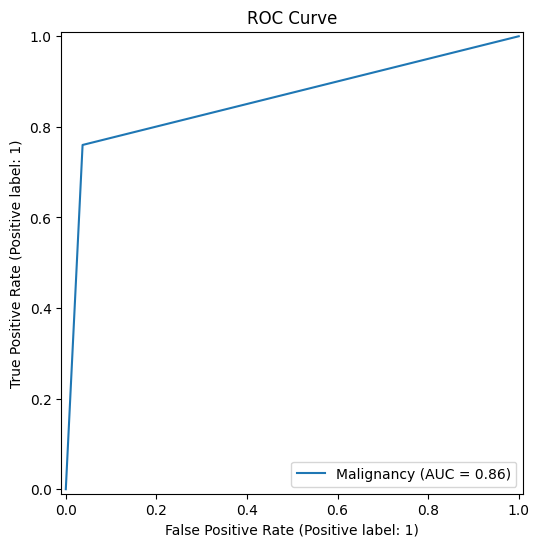

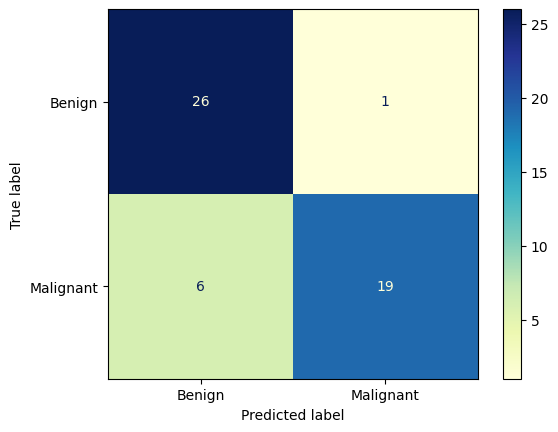

In [2]:
import pandas as pd
import numpy as np
import preprocessor as prep
import matplotlib.pyplot as plt
import ipywidgets as widgets

from ipywidgets import interactive, TwoByTwoLayout
from sklearn import set_config
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, RocCurveDisplay

# set output grid for displays
grid_section_layout = {'border': 'solid 2px blue', 'justify-content': 'center'}
bottom_left_out = widgets.Output(layout=grid_section_layout)
top_left_out = widgets.Output(layout=grid_section_layout)
out_grid = TwoByTwoLayout(top_left=top_left_out,
                          bottom_left=bottom_left_out,
                          height='95%',
                          width='95%',
                          grid_gap='5px')

# (layout={'display': 'flex', 'flex_flow': 'column', 'align_items': 'stretch', 
#                              'border': 'solid 2px blue', 'width': '80%', 'align-content': 'space-around'})

# set sklearn output to be pandas for pipelines to work with DataFrames instead of arrays
set_config(transform_output="pandas")


# helper func for returning boolean list for feature selection
def x_feature_list(data):
    result = []
    for element in data:
        if element != 'S/N' and element != 'Diagnosis Result':
            result.append(element)
    return result


# CREATE DATAFRAME FROM CSV FILE
df_dtypes = {'S/N': np.int64, 'Year': pd.Int64Dtype(), 'Age': pd.Int64Dtype(), 'Menopause': np.int64,
             'Tumor Size (cm)': pd.Int64Dtype(), 'Inv-Nodes': pd.Int64Dtype(),
             'Breast': "category", 'Metastasis': pd.Int64Dtype(),
             'Breast Quadrant': "category", 'History': pd.Int64Dtype(),
             'Diagnosis Result': "category"}

# -- read data from csv file in the current directory
df = pd.read_csv("breast-cancer-dataset.csv",
                 na_values="#",
                 dtype=df_dtypes,
                 index_col='S/N')
# print('\nRAW DATAFRAME EXTRACTED FROM CSV FILE')
# df.info()
# print("\nREMOVING ALL ROWS WITH NULL STRING FIELDS")
try:
    cols_to_check = ["Year", "Menopause", "Inv-Nodes", "Metastasis", "History", "Breast", "Breast Quadrant"]
    df.dropna(subset=cols_to_check, inplace=True)
    # print("\nREMOVED NULL STRING ROWS, NEW DATAFRAME INFO BELOW:\n")
    # df.info()

except TypeError:
    print('Exception when removing null data')

# SETTING DATA AND TARGET
# print('\nSETTING DATA AND TARGET')
X, y = (df.filter(x_feature_list(df.columns))), (df.filter(["Diagnosis Result"]).map(lambda x: 1 if x == 'Malignant'
else 0, na_action='ignore').squeeze())
# encode target variables
# VALIDATE X, y
# print('\nVALIDATING X\n')
# X.info()
# print('\nVALIDATING y\n')
# y.info()
# print('\nshape of y:')
# print(y.shape)


# CALL PREPROCESSOR
preprocessor = prep.preprocess()
# print('Preprocessor called\n')

# CLASSIFIER
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())],
    verbose=False,
)
clf.set_output(transform='pandas')
# print('\nCLASSIFIER PIPELINE BUILT\n')

# SPLIT DATA
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
# print("Data successfully split\n")

# RUN DATA THROUGH PREPROCESSOR
# print('FITTING TRAINING DATA TO PREPROCESSOR')
# try:
#     preprocessor.fit_transform(X_train, y_train)
# except Exception as e:
#     print(e)

# FIT DATA TO CLASSIFIER
clf.fit(X_train, y_train)
# print('CLASSIFIER READY: CLASSES SHOWN BELOW')
# print(clf.classes_)
# print('\nCLASSIFIER ACCURACY SCORE:')
clf_predict = clf.predict(X_test)

# CLASSIFICATION DISPLAY
top_left_out.append_stdout('Model Pipeline Structure')
top_left_out.append_display_data(clf)
print(classification_report(y_test, clf_predict, target_names=['Benign','Malignant']))

# ROC Curve Display
_, ax = plt.subplots(figsize=(12,6))
ax.set_title("ROC Curve")
ax.set_ylabel('True Positive Rate (Positive label: Malignant)')
ax.set_xlabel('False Positive Rate (Positive label: Malignant)')
display(RocCurveDisplay.from_predictions(y_test, clf_predict, name="Malignancy", ax=ax))

# Confusion Matrix Display
display(ConfusionMatrixDisplay.from_predictions(y_test, clf_predict, display_labels=['Benign', 'Malignant'], cmap='YlGnBu'))

# Interactive UI
def user_in(year, age, menopause, tumor_size, nodes, breast, metastasis, 
            breast_quad, fam_hist):
    data = {'Year': [year], 'Age': [age], 'Menopause': [menopause],
             'Tumor Size (cm)': [tumor_size], 'Inv-Nodes': [nodes],
             'Breast': [breast], 'Metastasis':[metastasis],
             'Breast Quadrant': [breast_quad], 'History': [fam_hist]}
    X_user = pd.DataFrame.from_dict(data)
    user_prediction = clf.predict(X_user)
    decision_func = clf.predict_proba(X_user)
    user_prob = lambda x: f'Probability: {abs(decision_func[0][0]*100):.2f}%' if x == 0 else f'Probability: {abs(decision_func[0][1]*100):.2f}%'
    user_results = lambda x: 'Malignant' if x == 1 else 'Benign'
    results_str = 'Your results are:'
    return display(results_str, user_results(user_prediction), user_prob(user_prediction))
    
user_display = interactive(user_in, {'manual': True}, 
                           year=(2019, 2020), 
                           age=(15, 80), 
                           menopause=False, 
                           tumor_size=(1, 10), 
                           nodes=False, 
                           breast=['Right', 'Left'], 
                           metastasis=False, 
                           breast_quad=['Upper outer', 'Lower outer', 'Upper inner', 'Lower outer'],
                           fam_hist=False)
bottom_left_out.append_stdout('USER INPUT FORM')
bottom_left_out.append_display_data(user_display)
out_grid